In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import xlsxwriter
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
#Read in all the csv data
path=r'/Users/tianj/Desktop/A0091898/CS5344/Project_TJ/resale-flat-prices'
all_files = glob.glob(path + "/*.csv")
HDB_df = pd.concat((pd.read_csv(f) for f in all_files),sort=False)

In [3]:
HDB_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65.0,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63.0,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64.0,290000.0


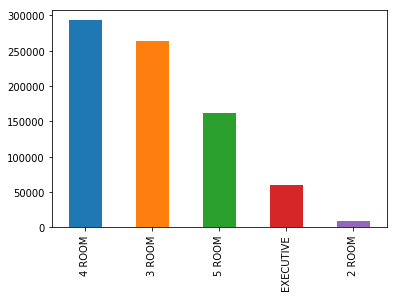

In [4]:
#We can see majority HDB flat types in Singapore are 4 ROOM/3 ROOM.
HDB_df['flat_type'].value_counts()[:5].plot(kind='bar')

In [5]:
#Create Year Column in dataset based on month column
HDB_df['year'] = pd.DatetimeIndex(HDB_df['month']).year

In [6]:
#Check if the data set containing NULL values.
HDB_df.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
remaining_lease        709998
resale_price                0
year                        0
dtype: int64

In [7]:
# To check Overall HDB resale price over the years, from 1990~2018
HDB_df_Year = HDB_df.groupby(['year'],as_index=True).mean()[['resale_price']]

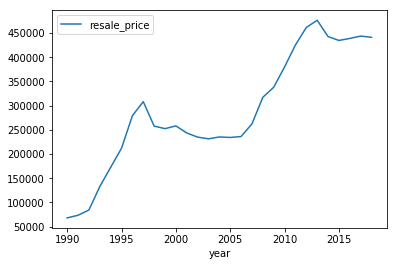

In [8]:
HDB_df_Year.plot(kind='line')

In [9]:
#After getting a rough idea for the dataset, next step is to identify features for model construction.
#In original dataset, there are no information regarding to nearby facilities like MRT/Shopping Mall,
#Which I believe are key factors for HDB resale price. 

In [10]:
#I solve this by querying the 'street_name' data from onemap.sg API and retrieve its longitude and latitude information
#and do the same thing for the MRT & Shopping Malls in Singapore. With the logitude and latitue inforamtion, I am able
#to calculate the Distance for different street with their nearest MRT/Shopping Malls.

In [11]:
#Function to calcualte the distance know the longtitude and latitude 
def calculate_distance(x,y):
    return np.sqrt(((x[0]-y[0])*110.574)**2 + ((x[1]-y[1])*111.32)**2)

In [12]:
Full_Data_df = pd.read_csv('Full_Data_Set.csv', low_memory=False)
Full_Data_df.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,LATITUDE,LONGITUDE,Distance_to_Raffles
0,0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,2015,103.838826,1.378136,10.679973
1,1,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,2015,103.838826,1.378136,10.679973
2,2,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,62.0,300000.0,2015,103.838826,1.378136,10.679973
3,3,2015-01,ANG MO KIO,3 ROOM,156,ANG MO KIO AVE 4,10 TO 12,68.0,New Generation,1981,65.0,312000.0,2015,103.838826,1.378136,10.679973
4,4,2015-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,07 TO 09,67.0,New Generation,1985,69.0,330000.0,2015,103.838826,1.378136,10.679973


In [13]:
#test_df.groupby('street_name').filter(lambda x: len(x) > 2 ).drop_duplicates(subset='street_name')

In [14]:
df_mrt = pd.read_csv('Street_Name_List.csv')
df_mrt.head()

,street_name,LATITUDE,LONGITUDE,MRT,Walk_Time_to_MRT,Shopping_Mall,Walk_Time_to_Mall
0,ANG MO KIO AVE 4,103.838826,1.378136,Yio Chu Kang,9.651508,Broadway Plaza,13.089647
1,ANG MO KIO AVE 10,103.855288,1.362654,Ang Mo Kio,12.523847,AMK Hub,13.150289
2,ANG MO KIO AVE 5,103.836172,1.378914,Yio Chu Kang,12.463429,Broadway Plaza,16.640269
3,ANG MO KIO AVE 8,103.844947,1.381756,Yio Chu Kang,0.497953,Broadway Plaza,13.732618
4,ANG MO KIO AVE 1,103.844819,1.365271,Ang Mo Kio,8.519570,AMK Hub,7.368627


In [15]:
#Full_Data_df.drop_duplicates(subset='street_name')[['street_name','LATITUDE','LONGITUDE']].to_excel('Address_without_MRT.xlsx',index=False)

In [16]:
Full_AddMRT_df = pd.merge(Full_Data_df,df_mrt[['street_name','MRT']],on='street_name')

In [17]:
Full_AddMRT_df.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,LATITUDE,LONGITUDE,Distance_to_Raffles,MRT
0,0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang
1,1,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang
2,2,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,62.0,300000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang
3,3,2015-01,ANG MO KIO,3 ROOM,156,ANG MO KIO AVE 4,10 TO 12,68.0,New Generation,1981,65.0,312000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang
4,4,2015-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,07 TO 09,67.0,New Generation,1985,69.0,330000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang


In [18]:
df_MRT_Travel_Time = pd.read_csv('MRT_List.csv')
df_MRT_Travel_Time.head()

,MRT,A,B,Travel_Time
0,Dhoby Ghaut,103.845226,1.299064,5.8
1,Boulevard,103.823869,1.302422,22.7
2,Tanjong Katong,103.897369,1.299319,28.1
3,Paya Lebar,103.892208,1.318370,13.5
4,MacPherson,103.889786,1.326689,18.8


In [19]:
Full_AddTime_df = pd.merge(Full_AddMRT_df,df_MRT_Travel_Time[['MRT','Travel_Time']],on='MRT')

In [20]:
#Full_Final_DF.to_csv('Full_Final.csv',index=True)

In [21]:
a_df = pd.read_csv('Full_Data_Set.csv')
a_df.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,LATITUDE,LONGITUDE,Distance_to_Raffles
0,0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,2015,103.838826,1.378136,10.679973
1,1,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,2015,103.838826,1.378136,10.679973
2,2,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,62.0,300000.0,2015,103.838826,1.378136,10.679973
3,3,2015-01,ANG MO KIO,3 ROOM,156,ANG MO KIO AVE 4,10 TO 12,68.0,New Generation,1981,65.0,312000.0,2015,103.838826,1.378136,10.679973
4,4,2015-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,07 TO 09,67.0,New Generation,1985,69.0,330000.0,2015,103.838826,1.378136,10.679973


In [22]:
temp_pd = pd.merge(a_df,df_mrt[['street_name','MRT','Walk_Time_to_MRT','Shopping_Mall','Walk_Time_to_Mall']],on='street_name')

In [23]:
temp_pd.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,LATITUDE,LONGITUDE,Distance_to_Raffles,MRT,Walk_Time_to_MRT,Shopping_Mall,Walk_Time_to_Mall
0,0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70.0,255000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647
1,1,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64.0,285000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647
2,2,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,62.0,300000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647
3,3,2015-01,ANG MO KIO,3 ROOM,156,ANG MO KIO AVE 4,10 TO 12,68.0,New Generation,1981,65.0,312000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647
4,4,2015-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,07 TO 09,67.0,New Generation,1985,69.0,330000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647


In [24]:
b_df = pd.read_csv('MRT_List.csv')

In [25]:
Full_Final_DF = pd.merge(temp_pd,b_df[['MRT','Travel_Time']],on='MRT')

In [26]:
Full_Final_DF.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,resale_price,year,LATITUDE,LONGITUDE,Distance_to_Raffles,MRT,Walk_Time_to_MRT,Shopping_Mall,Walk_Time_to_Mall,Travel_Time
0,0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,...,255000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7
1,1,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,...,285000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7
2,2,2015-01,ANG MO KIO,3 ROOM,109,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,...,300000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7
3,3,2015-01,ANG MO KIO,3 ROOM,156,ANG MO KIO AVE 4,10 TO 12,68.0,New Generation,1981,...,312000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7
4,4,2015-01,ANG MO KIO,3 ROOM,631,ANG MO KIO AVE 4,07 TO 09,67.0,New Generation,1985,...,330000.0,2015,103.838826,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7


In [27]:
#Full_Final_DF.to_csv('Full_Final_DF.csv',index=True)

In [28]:
#Full_Final_DF.astype({'year':int})

In [29]:
#Select only 4 Room flat types and data from year 2005 onwards for model construction. 4 Room HDB is the most common
#flat types in Singapore, and too aged data is not that helpful when predicting the future HDB resale price.
temp = Full_Final_DF[Full_Final_DF['flat_type'] == "4 ROOM"]
temp = temp[temp['year']>2005]

In [30]:
#Check the storey_range column, convert from string to a reasonable numeric number for input data.
#It is observed that majority are in the range of 3 to 5, so getting the mean value may be a good enough approximation. 
temp['storey_range'].unique()

array(['04 TO 06', '01 TO 03', '07 TO 09', '10 TO 12', '13 TO 15',
       '06 TO 10', '11 TO 15', '01 TO 05', '16 TO 18', '22 TO 24',
       '19 TO 21', '25 TO 27', '28 TO 30', '21 TO 25', '26 TO 30',
       '16 TO 20', '34 TO 36', '31 TO 33', '37 TO 39', '40 TO 42',
       '31 TO 35', '36 TO 40', '46 TO 48', '43 TO 45', '49 TO 51'],
      dtype=object)

In [31]:
# Define a funciton to pre-process the storey range data.
def get_mean_floor(x):
    return int((int(x[:2]) + int(x[-2:]))*0.5)

In [32]:
#Add processed storey column
temp['storey'] = temp['storey_range'].map(lambda x: get_mean_floor(x))

In [33]:
a_temp = temp.groupby(['town'],as_index=False).median()[['town','resale_price']]

In [34]:
#Define town_premium variable to as the difference between median price for each town and overall median resale price
a_temp['town_premium'] = a_temp['resale_price']-a_temp['resale_price'].median()

In [35]:
#Similat idea to get flat_model premium value based on the difference of respective model average and overall average
b_temp = temp.groupby(['flat_model'],as_index = False).median()[['flat_model','resale_price']]
b_temp['flat_model_premium'] = b_temp['resale_price']-b_temp['resale_price'].median()

In [36]:
x_df = pd.merge(temp, a_temp[['town','town_premium']],on='town')

In [37]:
#Feature Engineering for remain_lease, as the original "remaining_lease" column has a lot of missing values.
#Using year of 2018 as a reference year for remaining lease
temp['remain_lease'] = temp['lease_commence_date'] + 99 - temp['year']

In [38]:
y_df = pd.merge(x_df, b_temp[['flat_model','flat_model_premium']],on='flat_model')
y_df= y_df.drop(['Unnamed: 0'],axis=1)
y_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,LONGITUDE,Distance_to_Raffles,MRT,Walk_Time_to_MRT,Shopping_Mall,Walk_Time_to_Mall,Travel_Time,storey,town_premium,flat_model_premium
0,2015-01,ANG MO KIO,4 ROOM,612,ANG MO KIO AVE 4,04 TO 06,91.0,New Generation,1980,64.0,...,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7,5,21000.0,-24000.0
1,2015-01,ANG MO KIO,4 ROOM,177,ANG MO KIO AVE 4,01 TO 03,91.0,New Generation,1981,65.0,...,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7,2,21000.0,-24000.0
2,2015-01,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,07 TO 09,97.0,New Generation,1977,61.0,...,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7,8,21000.0,-24000.0
3,2015-01,ANG MO KIO,4 ROOM,117,ANG MO KIO AVE 4,10 TO 12,98.0,New Generation,1978,62.0,...,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7,11,21000.0,-24000.0
4,2015-02,ANG MO KIO,4 ROOM,175,ANG MO KIO AVE 4,04 TO 06,91.0,New Generation,1981,65.0,...,1.378136,10.679973,Yio Chu Kang,9.651508,Broadway Plaza,13.089647,24.7,5,21000.0,-24000.0


In [39]:
#y_df.to_csv('From_2005_4_Room.csv',index=True)